In [2]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
#from numpy.random import seed
#seed(1)
#tf.random.set_seed(1)

### Dataset
First we download the dataset and call it as 'data'

Now we define utility functions to read data and labels and get data augmentation
>### Notes
>$glob$ is a built-in phyton mudole, it is a general term used to define techniques to match specified patterns according to rules related to Unix shell. More practical, it is used to retrieve files/pathnames matching a specified pattern. we can also use wildcards (*, ?, [ranges]) apart from exact string search to make path retrieval more simple.

>$os$ module in Python provides functions for interacting with the operating system. In particular $os.path$ module contains some useful functions on pathnames. The path parameters are either strings or bytes . These functions here are used for different purposes such as for merging, normalizing and retrieving path names in python. The method $os.path.join( , )$ has two arguments. The first is a path-like object representing a file system path, the second represents the path components to be joined. 

>$.h5$ is a format for scientific data. It contains multidimentional arrays

In [3]:
array_tau = np.load('ntuples/dataset_tau.npy')
np.random.shuffle(array_tau)
array_tau = array_tau[:500000]
array_qcd = np.load('ntuples/dataset_fake_tau.npy')
np.random.shuffle(array_qcd)
array_qcd = array_qcd[:500000]
print(array_tau.shape)#with cut at 1 Milion events
print(array_qcd.shape)

(500000, 10, 8)
(500000, 10, 8)


### Preproccessing

track variables

In [29]:
#np.random.shuffle(array_tau)


big_array = np.append(array_tau[:500000,:,:7],array_qcd[:500000,:,:7], axis=0)#with cut at 1 Milion events
print(big_array.shape)
tot_max = np.max( np.max(big_array,axis=1), axis=0)
tot_max = np.append(tot_max, 1)
tot_min = np.min( np.min(big_array,axis=1), axis=0)
tot_min = np.append(tot_min, 0)
big_array_scaled = (big_array - tot_min[:7])/(tot_max[:7] - tot_min[:7])

array_tau_scaled = (array_tau - tot_min)/(tot_max - tot_min)
array_qcd_scaled = (array_qcd - tot_min)/(tot_max - tot_min)
#print(array_tau_scaled[len(array_tau_scaled)-1,:])
#print(big_array_scaled[len(array_tau_scaled)-1,:])

comparison = array_tau_scaled[:,:,:7] == big_array_scaled[:len(array_tau_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays) #Because of the cut, this will be False

(1000000, 10, 7)
True


Build test and train

In [30]:
train = {}
test = {}

test_percentage = 18#%
test_len = math.floor(len(array_tau)*test_percentage/100)
coordinates = []
[coordinates.append([True, True, False, False, False, False, False, False]) for i in range( 10 ) ]
coordinates = np.reshape(np.array(coordinates), ( 10, 8) )

test_len = 100000
test['features'] = array_tau_scaled[:test_len]
test['features'] = np.append(test['features'], array_qcd_scaled[:test_len], axis = 0)
test['points'] = np.reshape( test['features'][:,coordinates], ( len(test['features']), 10, 2) )
test['label'] = np.ones(test_len)
test['label'] = np.append(test['label'],np.zeros(test_len), axis = 0)

train_len = 300000
train['features'] = array_tau_scaled[test_len:train_len+test_len]
train['features'] = np.append(train['features'], array_qcd_scaled[test_len:train_len+test_len], axis = 0)
train['points'] = np.reshape( train['features'][:,coordinates], ( len(train['features']), 10, 2) )
train['label'] = np.ones( train_len )
train['label'] = np.append(train['label'], np.zeros(train_len), axis = 0)
print(train['label'][199999])

1.0


In [31]:
print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['label'].shape)
print(test['label'].shape)

(600000, 10, 2)
(200000, 10, 2)
(600000, 10, 8)
(200000, 10, 8)
(600000,)
(200000,)


In [32]:
# funzioni per dataugmentation (random traslation, rotations, jitter delle pointlcoud)
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud

def rotate_pointcloud(pointcloud):
    theta = np.pi*2 * np.random.uniform()
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    pointcloud[:,[0,2]] = pointcloud[:,[0,2]].dot(rotation_matrix) # random rotation (x,z)
    return pointcloud

def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud

def shuffle(dict_data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    shuffle_indices = np.arange( len(dict_data['points']))#Len data.points has to be the same for data.features and data.label
    np.random.shuffle(shuffle_indices)
    for k in dict_data:
        dict_data[k] = dict_data[k][shuffle_indices]
    return shuffle_indices, dict_data

### Model
Here we buid our net.

>### Note
>The method $tf.nn.top_k(input, k, name=None)$ returns the largest k numbers of each line in input, and return the index of their location.

>The method $tf.tile(input, multiplies, name=None)$ creates a new tensor by replicating input multiples times. The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, and the values of input are replicated multiples[i] times along the 'i'th dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].

>The method $tf.gather_nd(params, indices, batch_dims=0, name=None)$  slices from params into a Tensor with shape specified by indices. Whereas in tf.gather(...) indices defines slices into the first dimension of params, in tf.gather_nd(...), indices defines slices into the first N dimensions of params, where N = indices.shape[-1].

> The $tf.squeeze(input, axis=None, name=None)$ method, given a tensor input, returns a tensor of the same type with all dimensions of size $1$ removed. If you don't want to remove all size $1$ dimensions, you can remove specific size $1$ dimensions by specifying axis.

>$pass$ it is a null statement that is commonly used as a placeholder ('segnaposto').

> $tf.keras.Input()$ is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. For instance, if $a$, $b$ and $c$ are Keras tensors, it becomes possible to do: $model = Model(input=[a, b], output=c)$

In [33]:
#Positional Embedding
#Location Representation(frequencies)
def _cal_freq_list(setting):
    if setting.freq_init == "random":
        # the frequence we use for each block, alpha in ICLR paper
        # freq_list shape: (frequency_num)
        freq_list = np.random.random(size=[setting.frequency_num]) * setting.max_radius
    elif setting.freq_init == "geometric":

        log_timescale_increment = (math.log(float(setting.max_radius) / float(setting.min_radius)) /
          (setting.frequency_num*1.0 - 1))

        timescales = setting.min_radius * np.exp(
            np.arange(setting.frequency_num).astype(float) * log_timescale_increment)
        freq_list = 1.0/timescales
    return freq_list

def cal_freq_list(setting):
    freq_list = _cal_freq_list(setting)
    return freq_list

def cal_freq_mat(setting):
    # freq_mat shape: (frequency_num, 1)
    freq_mat = np.expand_dims(setting.freq_list, axis = 1)
    # self.freq_mat shape: (frequency_num, 3)
    freq_mat = np.repeat(freq_mat, 3, axis = 1)
    return freq_mat

def get_neighborhood_representation(setting, K, distances):
    '''
    Gets the Position Embedding of the pointpairs in the dataset based on relative distance
    '''
    setting.a = tf.constant([[1, 0], [-0.5, -math.sqrt(3) / 2], [-0.5, math.sqrt(3) / 2]])
    scales = tf.constant([setting.min_radius * (setting.max_radius / setting.min_radius) ** (s / (setting.frequency_num - 1)) for s in range(setting.frequency_num)])
    scaled_proj = tf.einsum('bnkr, s -> bnkrs', tf.einsum('ijkl,sl->ijks', distances, setting.a), 1 / scales)
    batch_size = tf.shape(scaled_proj)[0]
    neighborhood_representation = tf.concat((tf.cos(scaled_proj), tf.sin(scaled_proj)), axis=-1)
    neighborhood_representation = tf.reshape( neighborhood_representation, (batch_size, setting.num_points, K, setting.frequency_num*6) )
    return neighborhood_representation


def First_EdgeConv_layer (pts, fts, setting, K, channels, center_flags, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
    indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself
    knn_pts, _ = knn(setting.num_points, K, indices, pts, center_flags)  # (N, P, K, C), (N, P, K, 1) So we now use only coords of each point
    knn_fts, knn_flags = knn(setting.num_points, K, indices, fts, center_flags)  # (N, P, K, C), (N, P, K, 1)
    knn_pts_center = tf.tile(tf.expand_dims(pts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
    knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
    knn_deltapts = tf.abs(knn_pts_center - knn_pts)
    knn_deltafts = tf.abs(knn_fts_center - knn_fts)
    #spr_embeds = make_input_embeds(setting, K, knn_deltapts)
    spr_embeds = get_neighborhood_representation(setting, K, knn_deltapts)
    knn_fts_center = tf.concat([knn_pts_center, knn_fts_center], axis=-1)
    knn_deltafts = tf.concat([spr_embeds, knn_deltafts], axis=-1)
    knn_LocRep = tf.concat([knn_fts_center, knn_deltafts], axis=-1)  # (N, P, K, C + 6*freq_num); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato
    print("knn_LocRep shape =", tf.shape(knn_LocRep),"\n")
    x = knn_LocRep
    for idx, channel in enumerate(channels):
        x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
        if with_bn:
            x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
        if activation:
            x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)
    """
    if pooling == 'max':
        fts = tf.reduce_max(x, axis=2)  # (N, P, C')
    else:
        fts = tf.reduce_mean(x, axis=2)  # (N, P, C')
    """
    return x, knn_flags


#PointPairAttentionLayer
from keras.layers import Layer

class PointPairAttLayer(Layer):
    def __init__(self, output_dim, num_categ, name, **kwargs):
        super().__init__(**kwargs)   #PointPairAttLayer, self
        self.output_dim = output_dim
        self.num_categ = num_categ
        #self.in_features = in_features é un argomento evitabile se si usa input_shape
        self.string = name
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "num_categ": self.num_categ,
            "name": self.string,
        })
        return config
    def build(self, input_shape):
        self.W = self.add_weight(name = 'W_linOp_'+self.string, shape = (input_shape[3], self.output_dim), initializer = 'glorot_uniform', trainable = True) #is square lin alg
        ### l'originale usa num_classes, assumo intendessero le categorie e uso num_categ = 4
        self.n_perms = sum([self.num_categ-x for x in range(self.num_categ)]) # Number of order-invariant pointpair permutations
        self.a_pair = self.add_weight(name = 'a_pair_'+self.string, shape = ( self.n_perms, input_shape[3]), initializer = 'glorot_uniform', trainable = True)
        #self.a_self = self.add_weight(name = 'a_self_'+self.string, shape = ( self.num_categ, input_shape[3]), initializer = 'glorot_uniform', trainable = True)

    def call(self, input_data, center_flags, knn_flags, K):
        Wx = tf.einsum('ijkc,ss->ijks',input_data, self.W)
        center_flags = tf.tile( center_flags, (1,1,K)) #(N, P, K)
        #center_flags = tf.expand_dims( center_flags , axis = 3)     #(N, P, K, 1) se metto questo devo togliere la linea dopo, e ho una dim in più dell'originale
        knn_flags = tf.squeeze( knn_flags, axis = 3) #(N, P, K)
        stack = tf.stack( (knn_flags, center_flags ) )#(2, N, P, K) ?é giusto? loro hanno una dimensione in meno
        stack = tf.sort( stack, axis = 0) #Lui prende il più piccolo della coppia, ma secondo me ha più senso prendere entrambi, visto poi come lo usa...
        ## create a
        a = tf.ones( tf.shape(input_data) ) #(N, P, K, C)
        n = 0
        list_categ = np.array([-9.00000000e+00,1.00000000e+00, 2.00000000e+00, 3.00000000e+00])
        for i in list_categ:
            for j in list_categ[list_categ >= i]:
                mask = tf.expand_dims( tf.gather(stack, 0) == i, axis=-1) & tf.expand_dims( tf.gather(stack, 1) == j, axis=-1) #(N P, K, 1)
                a = tf.where( mask, tf.gather( self.a_pair, n), a) #(N, P, K, C) with tf.gather() has shape = (C)
                n += 1
        ## creare output
        x = keras.layers.LeakyReLU( name = 'leakyReLU_on_Wxa_'+self.string)(Wx * a)
        atten = keras.layers.Softmax( axis = 2, name = 'softmax_on_Wxa_'+self.string )(x) #( N, P, C)
        x = keras.layers.ELU( name = 'ELU_on_WxaWx_'+self.string)(atten * Wx)
        return x
    def compute_output_shape(self, input_shape): return (input_shape[0], self.output_dim)


#DGCNN

# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):#It gives a name_scope at submitted operators, so 'r_A', when executed, will have name 'dmat/r_A'
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))#'Distance' between A and B
        return tf.math.sqrt(D)
    
def knn(num_points, k, topk_indices, features, center_flags): #k-nearest-neighbours
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1)) #(N, P, K, 1)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2) indices ha, per ogni elemento, due numeri: il primo scala rispetto al batch
        knn_flags = tf.gather_nd(center_flags, indices)
        return tf.gather_nd(features, indices), knn_flags
    
def edge_conv(points, features, num_points, K, channels, center_flags=None, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    """EdgeConv
    Args:
        num_points: number of points per event (1024)
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
        indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself

        fts = features # (N, P, C)
        knn_fts, knn_flags = knn(num_points, K, indices, fts, center_flags)  # (N, P, K, C), (N, P, K, 1)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato
        ### nel passaggio sopra lui accoppia le fts del nodo di riferimento e LA DIFFERENZA del k-vicino con questo...
        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)
        #ppa = PointPairAttLayer( output_dim = channel, num_categ = 4, name = '%s_ppa_conv%d' %  (name,idx) )
        #ppa1 = PointPairAttLayer( output_dim = channel, num_categ = 4, name = '%s_ppa_conv%d' %  (name,idx) )
        #print("knn before enter ppa = ", tf.shape(knn_flags))
        #x_0 = self.ppa(x, center_flags, knn_flags, K)#it takes call method and by defould calls also build method, givind to this the input shape
        #x_1 = self.ppa1(x, center_flags, knn_flags, K)
        #x = tf.concat([ tf.expand_dims(x_0, axis = -1), tf.expand_dims(x_1, axis = -1)], axis = -1)
        #x = tf.reduce_mean(x, axis=-1)  # (N, P, K, C')
        """
        if pooling == 'max': ##Cutted By edgeconv__
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')
        """
        return x, knn_flags


def _DGCNN_base(points, features=None, setting=None, fts_dict=None, name='DGCNN_SG'): #it is used by get_DGCNN to build the net
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optional

    with tf.name_scope(name):
        if features is None:
            features = points
            
        #fts = features
        center_flags = tf.gather(features, [7], axis = 2)
        setting.ppa_ly1 = PointPairAttLayer( output_dim = 8, num_categ = 4, name = '%s_ppa_conv_0_ly1' %  name )
        setting.ppa1_ly1 = PointPairAttLayer( output_dim = 8, num_categ = 4, name = '%s_ppa_conv_1_ly1' %  name )
        setting.ppa2_ly1 = PointPairAttLayer( output_dim = 8, num_categ = 4, name = '%s_ppa_conv_2_ly1' %  name )
        setting.ppa_ly2 = PointPairAttLayer( output_dim = 16, num_categ = 4, name = '%s_ppa_conv_0_ly2' %  name )
        setting.ppa1_ly2 = PointPairAttLayer( output_dim = 16, num_categ = 4, name = '%s_ppa_conv_1_ly2' %  name )
        setting.ppa2_ly2 = PointPairAttLayer( output_dim = 16, num_categ = 4, name = '%s_ppa_conv_2_ly2' %  name )
        for layer_idx, layer_param in enumerate(setting.conv_params):# Here creates the 4 edge_conv layers
            K, channels = layer_param
            #pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts) #nell'originale prende points solo la prima volta, ma li pts e fts coincidono quindi è uguale...
            if layer_idx == 0:
                pts = points
                fts = tf.gather(features, [2,3,4,5,6,7], axis = 2)
                fts, knn_flags = First_EdgeConv_layer(pts, fts, setting, K, channels, center_flags, with_bn=True, activation='relu',
                                    pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))
            else :
                pts = fts # o features??
                fts, knn_flags = edge_conv(pts, fts, setting.num_points, K, channels, center_flags, with_bn=True, activation='relu',
                                pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))
            if layer_idx == 0:
                x_0 = setting.ppa_ly1(fts, center_flags, knn_flags, K)#it takes call method and by defould calls also build method, givind to this the input shape
                x_1 = setting.ppa1_ly1(fts, center_flags, knn_flags, K)
                x_2 = setting.ppa2_ly1(fts, center_flags, knn_flags, K)
            else:
                x_0 = setting.ppa_ly2(fts, center_flags, knn_flags, K)#it takes call method and by defould calls also build method, givind to this the input shape
                x_1 = setting.ppa1_ly2(fts, center_flags, knn_flags, K)
                x_2 = setting.ppa2_ly2(fts, center_flags, knn_flags, K)
            fts = tf.concat([ tf.expand_dims(x_0, axis = -1), tf.expand_dims(x_1, axis = -1), tf.expand_dims(x_2, axis = -1)], axis = -1)
            fts = tf.reduce_mean(fts, axis=-1)  # (N, P, K, C')
            fts = tf.reduce_mean(fts, axis=2)  # (N, P, C')
            #string = 'fts_%d' % (layer_idx)
            #fts_dict[string]=fts
            
        #fts = tf.concat([fts_dict['fts_0'], fts_dict['fts_1'], fts_dict['fts_2'], fts_dict['fts_3']], axis=-1)
        #fts = keras.layers.Dense(32, activation='relu')(fts)#(N,P,32=C) ##HERE IS DIFFERENCEEE 32 instead of setting.num_points
        pool_avg = tf.reduce_mean(fts, axis=1, name='pool_mean')  # (N, C)
        pool_max = tf.reduce_max(fts, axis=1, name='pool_max')  # (N, C)  ### HERE
        pool = tf.concat([pool_avg,pool_max], axis=-1, name='pool_concat') #(N,2*C)
        #pool = tf.reduce_mean(fts, axis=1)  # (N, C)
        
            
        if setting.fc_params is not None:#Here it creates the FC layers
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='sigmoid')(x) ###Sigmoid for 1-dim output, not softmax
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass

def get_DGCNN(num_classes, input_shapes):#Here we set all parameters of the net, its structure and then the _DGCNN_base really create it

    fts_dict = {}
    setting = _DotDict()
    setting.num_class = num_classes
    #setting of Location Representation
    setting.freq_init = "geometric"
    setting.frequency_num = 5
    setting.max_radius = 100
    setting.min_radius = 1
    setting.unit_vec1 = tf.constant([1.0, 0.0],dtype = float)                    # 0  we need tf_constant to use them with tf_tensor
    setting.unit_vec2 = tf.constant([-1.0/2.0, math.sqrt(3)/2.0])  # 120 degree
    setting.unit_vec3 = tf.constant([-1.0/2.0, -math.sqrt(3)/2.0]) # 240 degree
    setting.freq_list = cal_freq_list(setting)
    setting.freq_mat = cal_freq_mat(setting)
    # conv_params: list of tuple in the format (K, (C1, C2, C3)); where c1, c2, c3 are MLP layers inside each edge conv, respectiveli...so at each edge coonv layer we can use dfferent numbers and lists
    setting.conv_params = [
        (3, (8,)), #First EdgeConv Layer
        (3, (16,)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [
        (64, 0.5),
        (32, 0.5),
        ]
    setting.num_points = input_shapes['points'][0]# = 10


    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    outputs = _DGCNN_base(points, features, setting, name='DGCNN_SG')# fts_dict,
    
    return keras.Model(inputs=[points, features], outputs=outputs, name='DGCNN_SG')


In [34]:
num_classes = 1#only tau
input_shapes = {k:train[k].shape[1:] for k in train}
print(input_shapes)
model = get_DGCNN(num_classes, input_shapes)

{'features': (10, 8), 'points': (10, 2), 'label': ()}
knn_LocRep shape = KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 10, 3, 44], name='tf.compat.v1.shape_17/Shape:0', description="created by layer 'tf.compat.v1.shape_17'") 



In [35]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-03-24 16:37:06,743] INFO: Learning rate: 0.001000


Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_10 (TFOp (None, 2, 10)        0           points[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_15 (TFOpLambda (None, 10, 2)        0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf.linalg.matmul_5 (TFOpLambda) (None, 10, 10)       0           points[0][0]              

In [37]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

In [38]:
# Training parameters
batch_size = 512
epochs = 50

In [39]:
shuffled_ind, train = shuffle(train)
shuffled_ind, test = shuffle(test)
lim_data = len(train['points'])
history = model.fit( [train['points'][:lim_data],train['features'][:lim_data]],
                    train['label'][:lim_data],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data= ( [test['points'][:50000],test['features'][:50000]], test['label'][:50000]),
                    #validation_split = 0.15,
                    shuffle=True,
                    callbacks=callbacks)

[2022-03-24 16:37:07,740] INFO: Learning rate: 0.001000


Epoch 1/50


2022-03-24 16:37:12.004493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: Invalid argument: Size of values 1 does not match size of permutation 4 @ fanin shape inDGCNN_SG/point_pair_att_layer_15/SelectV2-1-TransposeNHWCToNCHW-LayoutOptimizer


1171/1172 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.7211

2022-03-24 16:38:03.735460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: Invalid argument: Size of values 1 does not match size of permutation 4 @ fanin shape inDGCNN_SG/point_pair_att_layer_15/SelectV2-1-TransposeNHWCToNCHW-LayoutOptimizer


1172/1172 [==============================] - 59s 46ms/step - loss: 0.5672 - accuracy: 0.7211 - val_loss: 0.5451 - val_accuracy: 0.7317


[2022-03-24 16:38:06,708] INFO: Learning rate: 0.001000



Epoch 00001: val_accuracy improved from -inf to 0.73174, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 2/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5523 - accuracy: 0.7324 - val_loss: 0.5541 - val_accuracy: 0.7319


[2022-03-24 16:38:59,731] INFO: Learning rate: 0.001000



Epoch 00002: val_accuracy improved from 0.73174 to 0.73194, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 3/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5509 - accuracy: 0.7332 - val_loss: 0.5692 - val_accuracy: 0.7244


[2022-03-24 16:39:52,556] INFO: Learning rate: 0.001000



Epoch 00003: val_accuracy did not improve from 0.73194
Epoch 4/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5497 - accuracy: 0.7333 - val_loss: 0.5442 - val_accuracy: 0.7315


[2022-03-24 16:40:45,884] INFO: Learning rate: 0.001000



Epoch 00004: val_accuracy did not improve from 0.73194
Epoch 5/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5488 - accuracy: 0.7336 - val_loss: 0.5865 - val_accuracy: 0.7133


[2022-03-24 16:41:39,198] INFO: Learning rate: 0.001000



Epoch 00005: val_accuracy did not improve from 0.73194
Epoch 6/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5487 - accuracy: 0.7340 - val_loss: 0.5540 - val_accuracy: 0.7295


[2022-03-24 16:42:32,492] INFO: Learning rate: 0.001000



Epoch 00006: val_accuracy did not improve from 0.73194
Epoch 7/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5482 - accuracy: 0.7343 - val_loss: 0.5769 - val_accuracy: 0.7179


[2022-03-24 16:43:25,454] INFO: Learning rate: 0.001000



Epoch 00007: val_accuracy did not improve from 0.73194
Epoch 8/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5477 - accuracy: 0.7345 - val_loss: 0.5512 - val_accuracy: 0.7311


[2022-03-24 16:44:18,428] INFO: Learning rate: 0.001000



Epoch 00008: val_accuracy did not improve from 0.73194
Epoch 9/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5471 - accuracy: 0.7356 - val_loss: 0.5491 - val_accuracy: 0.7297


[2022-03-24 16:45:11,618] INFO: Learning rate: 0.001000



Epoch 00009: val_accuracy did not improve from 0.73194
Epoch 10/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5463 - accuracy: 0.7355 - val_loss: 0.5459 - val_accuracy: 0.7299


[2022-03-24 16:46:04,740] INFO: Learning rate: 0.001000



Epoch 00010: val_accuracy did not improve from 0.73194
Epoch 11/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5454 - accuracy: 0.7359 - val_loss: 0.5941 - val_accuracy: 0.6935


[2022-03-24 16:46:58,091] INFO: Learning rate: 0.000100



Epoch 00011: val_accuracy did not improve from 0.73194
Epoch 12/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5436 - accuracy: 0.7376 - val_loss: 0.5367 - val_accuracy: 0.7364


[2022-03-24 16:47:51,462] INFO: Learning rate: 0.000100



Epoch 00012: val_accuracy improved from 0.73194 to 0.73642, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 13/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5434 - accuracy: 0.7377 - val_loss: 0.5428 - val_accuracy: 0.7339


[2022-03-24 16:48:44,253] INFO: Learning rate: 0.000100



Epoch 00013: val_accuracy did not improve from 0.73642
Epoch 14/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5434 - accuracy: 0.7374 - val_loss: 0.5371 - val_accuracy: 0.7366


[2022-03-24 16:49:37,463] INFO: Learning rate: 0.000100



Epoch 00014: val_accuracy improved from 0.73642 to 0.73662, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 15/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5434 - accuracy: 0.7379 - val_loss: 0.5422 - val_accuracy: 0.7308


[2022-03-24 16:50:30,766] INFO: Learning rate: 0.000100



Epoch 00015: val_accuracy did not improve from 0.73662
Epoch 16/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5431 - accuracy: 0.7378 - val_loss: 0.5372 - val_accuracy: 0.7358


[2022-03-24 16:51:23,891] INFO: Learning rate: 0.000100



Epoch 00016: val_accuracy did not improve from 0.73662
Epoch 17/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5432 - accuracy: 0.7379 - val_loss: 0.5368 - val_accuracy: 0.7357


[2022-03-24 16:52:16,984] INFO: Learning rate: 0.000100



Epoch 00017: val_accuracy did not improve from 0.73662
Epoch 18/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5431 - accuracy: 0.7380 - val_loss: 0.5402 - val_accuracy: 0.7338


[2022-03-24 16:53:10,074] INFO: Learning rate: 0.000100



Epoch 00018: val_accuracy did not improve from 0.73662
Epoch 19/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5429 - accuracy: 0.7381 - val_loss: 0.5450 - val_accuracy: 0.7327


[2022-03-24 16:54:03,077] INFO: Learning rate: 0.000100



Epoch 00019: val_accuracy did not improve from 0.73662
Epoch 20/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5429 - accuracy: 0.7386 - val_loss: 0.5398 - val_accuracy: 0.7358


[2022-03-24 16:54:55,871] INFO: Learning rate: 0.000100



Epoch 00020: val_accuracy did not improve from 0.73662
Epoch 21/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5426 - accuracy: 0.7388 - val_loss: 0.5477 - val_accuracy: 0.7261


[2022-03-24 16:55:49,072] INFO: Learning rate: 0.000100



Epoch 00021: val_accuracy did not improve from 0.73662
Epoch 22/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5428 - accuracy: 0.7384 - val_loss: 0.5373 - val_accuracy: 0.7376


[2022-03-24 16:56:42,182] INFO: Learning rate: 0.000100



Epoch 00022: val_accuracy improved from 0.73662 to 0.73756, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 23/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5424 - accuracy: 0.7384 - val_loss: 0.5370 - val_accuracy: 0.7354


[2022-03-24 16:57:35,202] INFO: Learning rate: 0.000100



Epoch 00023: val_accuracy did not improve from 0.73756
Epoch 24/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5422 - accuracy: 0.7386 - val_loss: 0.5400 - val_accuracy: 0.7362


[2022-03-24 16:58:27,964] INFO: Learning rate: 0.000100



Epoch 00024: val_accuracy did not improve from 0.73756
Epoch 25/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5423 - accuracy: 0.7389 - val_loss: 0.5466 - val_accuracy: 0.7259


[2022-03-24 16:59:21,166] INFO: Learning rate: 0.000100



Epoch 00025: val_accuracy did not improve from 0.73756
Epoch 26/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5424 - accuracy: 0.7388 - val_loss: 0.5361 - val_accuracy: 0.7366


[2022-03-24 17:00:14,279] INFO: Learning rate: 0.000100



Epoch 00026: val_accuracy did not improve from 0.73756
Epoch 27/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5424 - accuracy: 0.7382 - val_loss: 0.5362 - val_accuracy: 0.7362


[2022-03-24 17:01:07,737] INFO: Learning rate: 0.000100



Epoch 00027: val_accuracy did not improve from 0.73756
Epoch 28/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5418 - accuracy: 0.7388 - val_loss: 0.5374 - val_accuracy: 0.7377


[2022-03-24 17:02:01,099] INFO: Learning rate: 0.000100



Epoch 00028: val_accuracy improved from 0.73756 to 0.73768, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 29/50
1172/1172 [==============================] - 54s 46ms/step - loss: 0.5422 - accuracy: 0.7386 - val_loss: 0.5350 - val_accuracy: 0.7374


[2022-03-24 17:02:54,629] INFO: Learning rate: 0.000100



Epoch 00029: val_accuracy did not improve from 0.73768
Epoch 30/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5416 - accuracy: 0.7392 - val_loss: 0.5383 - val_accuracy: 0.7340


[2022-03-24 17:03:48,030] INFO: Learning rate: 0.000100



Epoch 00030: val_accuracy did not improve from 0.73768
Epoch 31/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5419 - accuracy: 0.7389 - val_loss: 0.5451 - val_accuracy: 0.7267


[2022-03-24 17:04:41,168] INFO: Learning rate: 0.000100



Epoch 00031: val_accuracy did not improve from 0.73768
Epoch 32/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5416 - accuracy: 0.7390 - val_loss: 0.5376 - val_accuracy: 0.7379


[2022-03-24 17:05:34,264] INFO: Learning rate: 0.000100



Epoch 00032: val_accuracy improved from 0.73768 to 0.73786, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 33/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5414 - accuracy: 0.7393 - val_loss: 0.5381 - val_accuracy: 0.7375


[2022-03-24 17:06:27,500] INFO: Learning rate: 0.000100



Epoch 00033: val_accuracy did not improve from 0.73786
Epoch 34/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5415 - accuracy: 0.7390 - val_loss: 0.5366 - val_accuracy: 0.7351


[2022-03-24 17:07:20,875] INFO: Learning rate: 0.000100



Epoch 00034: val_accuracy did not improve from 0.73786
Epoch 35/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5414 - accuracy: 0.7390 - val_loss: 0.5348 - val_accuracy: 0.7373


[2022-03-24 17:08:14,328] INFO: Learning rate: 0.000100



Epoch 00035: val_accuracy did not improve from 0.73786
Epoch 36/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5414 - accuracy: 0.7394 - val_loss: 0.5395 - val_accuracy: 0.7352


[2022-03-24 17:09:07,737] INFO: Learning rate: 0.000100



Epoch 00036: val_accuracy did not improve from 0.73786
Epoch 37/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5413 - accuracy: 0.7394 - val_loss: 0.5394 - val_accuracy: 0.7357


[2022-03-24 17:10:01,233] INFO: Learning rate: 0.000100



Epoch 00037: val_accuracy did not improve from 0.73786
Epoch 38/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5411 - accuracy: 0.7395 - val_loss: 0.5454 - val_accuracy: 0.7308


[2022-03-24 17:10:54,671] INFO: Learning rate: 0.000100



Epoch 00038: val_accuracy did not improve from 0.73786
Epoch 39/50
1172/1172 [==============================] - 54s 46ms/step - loss: 0.5412 - accuracy: 0.7393 - val_loss: 0.5468 - val_accuracy: 0.7291


[2022-03-24 17:11:48,202] INFO: Learning rate: 0.000100



Epoch 00039: val_accuracy did not improve from 0.73786
Epoch 40/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5410 - accuracy: 0.7396 - val_loss: 0.5401 - val_accuracy: 0.7311


[2022-03-24 17:12:41,502] INFO: Learning rate: 0.000100



Epoch 00040: val_accuracy did not improve from 0.73786
Epoch 41/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5410 - accuracy: 0.7400 - val_loss: 0.5468 - val_accuracy: 0.7291


[2022-03-24 17:13:34,523] INFO: Learning rate: 0.000100



Epoch 00041: val_accuracy did not improve from 0.73786
Epoch 42/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5410 - accuracy: 0.7400 - val_loss: 0.5341 - val_accuracy: 0.7385


[2022-03-24 17:14:27,857] INFO: Learning rate: 0.000100



Epoch 00042: val_accuracy improved from 0.73786 to 0.73846, saving model to model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5
Epoch 43/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5410 - accuracy: 0.7399 - val_loss: 0.5552 - val_accuracy: 0.7164


[2022-03-24 17:15:21,074] INFO: Learning rate: 0.000100



Epoch 00043: val_accuracy did not improve from 0.73846
Epoch 44/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.5409 - accuracy: 0.7397 - val_loss: 0.5417 - val_accuracy: 0.7329


[2022-03-24 17:16:14,554] INFO: Learning rate: 0.000100



Epoch 00044: val_accuracy did not improve from 0.73846
Epoch 45/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5408 - accuracy: 0.7399 - val_loss: 0.5399 - val_accuracy: 0.7347


[2022-03-24 17:17:07,776] INFO: Learning rate: 0.000100



Epoch 00045: val_accuracy did not improve from 0.73846
Epoch 46/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5407 - accuracy: 0.7401 - val_loss: 0.5462 - val_accuracy: 0.7276


[2022-03-24 17:18:01,093] INFO: Learning rate: 0.000100



Epoch 00046: val_accuracy did not improve from 0.73846
Epoch 47/50
1172/1172 [==============================] - 53s 45ms/step - loss: 0.5410 - accuracy: 0.7400 - val_loss: 0.5421 - val_accuracy: 0.7315


[2022-03-24 17:18:54,314] INFO: Learning rate: 0.000100



Epoch 00047: val_accuracy did not improve from 0.73846
Epoch 48/50
1172/1172 [==============================] - 54s 46ms/step - loss: 0.5404 - accuracy: 0.7401 - val_loss: 0.5350 - val_accuracy: 0.7380


[2022-03-24 17:19:47,857] INFO: Learning rate: 0.000100



Epoch 00048: val_accuracy did not improve from 0.73846
Epoch 49/50
1172/1172 [==============================] - 52s 44ms/step - loss: 0.5408 - accuracy: 0.7404 - val_loss: 0.5688 - val_accuracy: 0.7051


[2022-03-24 17:20:39,629] INFO: Learning rate: 0.000100



Epoch 00049: val_accuracy did not improve from 0.73846
Epoch 50/50
1172/1172 [==============================] - 52s 44ms/step - loss: 0.5404 - accuracy: 0.7402 - val_loss: 0.5446 - val_accuracy: 0.7298

Epoch 00050: val_accuracy did not improve from 0.73846


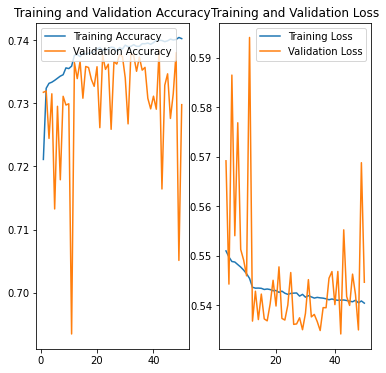

In [40]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[0:], mae[0:], label='Training Accuracy')
plt.plot(epochs_range[0:], val_mae[0:], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[2:], loss[2:], label='Training Loss')
plt.plot(epochs_range[2:], val_loss[2:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
test_loss, test_acc = model.evaluate( [test['points'],test['features']], test['label'], verbose=2, batch_size = batch_size)

391/391 - 11s - loss: 0.5413 - accuracy: 0.7318


In [42]:
model.load_weights("model_checkpoints/simple_MC-DGCNN-2PPA_on_Tau_only_tracks.h5")#DGCNN_on_Tau.h5

In [43]:
test_loss, test_acc = model.evaluate( [test['points'],test['features']], test['label'], verbose=2, batch_size = batch_size)

391/391 - 11s - loss: 0.5304 - accuracy: 0.7421


### ROC curve

In [44]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

In [45]:
predicted_data = model.predict([test['points'],test['features'],test['Glob_features']], batch_size = batch_size, verbose = 1)

KeyError: 'Glob_features'

In [ ]:
# calculate precision and recall
# True Positive
tp = len(test['label'][(test['label'] == 0) & (predicted_data == 0)])
# False Positive -- predict anomaly (-1), when it is actually normal (1)
fp = len(test['label'][(test['label'] == 1) & (predicted_data == 0)])
# True Negative
tn = len(test['label'][(test['label'] == 1) & (predicted_data == 1)])
# False Negative
fn = len(test['label'][(test['label'] == 0) & (predicted_data == 1)])

In [ ]:
# precision/recall
pre_score = tp / (tp + fp)
re_score = tp / (tp + fn)
# tpr/fpr
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

### Study of dataset

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


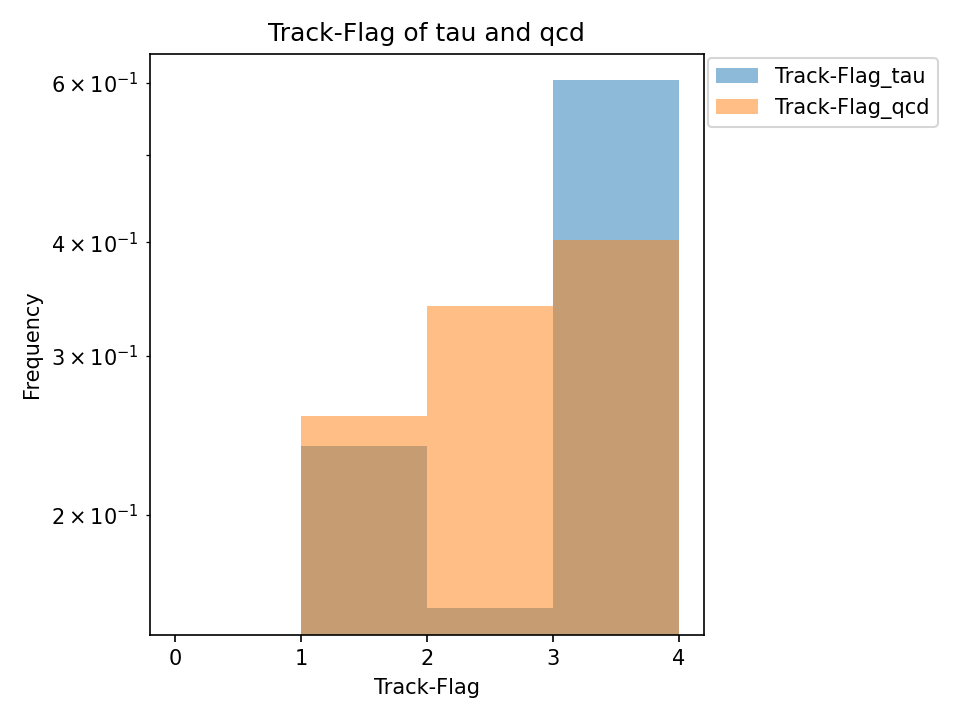

In [5]:
set_variable = ['DeltaEta', 'DeltaPhi', 'Pt', 'E', 'd0', 'z0', 'theta', 'Track-Flag']
mask = [-9, -9, -999, -999, -999, -999, -999, -9]
xlow = [-0.7, -0.7, 0, 0, -200, -300, 0, 0]
xup = [0.7, 0.7, 10**9, 10**9, 200, 300, 3.25, 4]
setted_var = 7 #btw 0 and 3
#cleaning of variable from mask and values bigger than 10**9
a = array_tau[:,:,setted_var]#
b = array_qcd[:,:,setted_var]#test['features']
c =  (a != mask[setted_var])
d =  (b != mask[setted_var])
a = a[c]
b = b[d]

n_bins=4
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(a, bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
ax1.hist(b, bins=n_bins , label=set_variable[setted_var]+'_qcd', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and qcd")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

In [51]:
array_tau = np.load('ntuples/dataset_tau.npy')
selected_class = 1
classes = [-9.00000000e+00,1.00000000e+00, 2.00000000e+00, 3.00000000e+00, None]
#cleaning of variable from mask
tau_dEta = array_tau[:,:,0]
tau_dPhi = array_tau[:,:,1]
c =  (tau_dEta != -9)
dR = np.ones(c.shape) - 3

for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        if c[i,j] and array_tau[i,j,7] == classes[selected_class] :
            dR[i,j] = np.sqrt( tau_dEta[i,j]**2 + tau_dPhi[i,j]**2 )
dR = np.reshape(dR, c.shape[0]*c.shape[1])

Text(0, 0.5, 'Frequency')

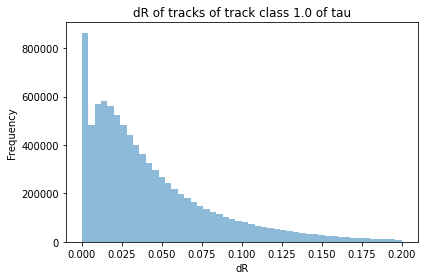

In [52]:
xlow = [0, 0, 0, 0, 0]
xup = [0, 0.2, 0.5, 0.6, 0.6] #class 1 arrives until 0.55
n_bins=50

c = dR != -2
dR = dR[c]

fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
#To normalize histograms we set density=True, to get area = 1
ax.hist(dR, bins=n_bins , lw=0.5, alpha=0.5, range=[xlow[selected_class], xup[selected_class]] )
plt.title("dR of tracks of track class "+str(classes[selected_class])+" of tau")
plt.xlabel("dR")
plt.ylabel("Frequency")
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.set_yscale('log')
#ax1.set_yscale('log')

Number of true trcks

In [11]:
array_tau = np.load('ntuples/dataset_tau.npy')
a = array_tau[:,:,2]
c =  (a != -999)
d = np.zeros(c.shape[0])
for i in range(c.shape[0]):
    track_counter = 0
    for j in range(10):
        if c[i,j]:
            track_counter +=1
    d[i] = track_counter

<IPython.core.display.Javascript object>


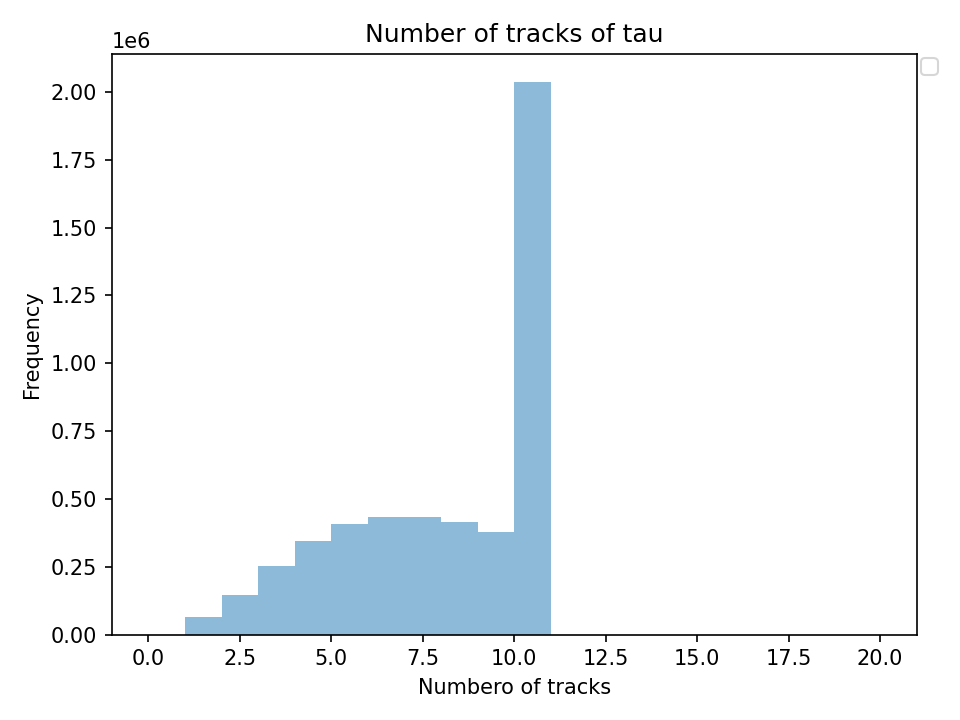

No handles with labels found to put in legend.


In [15]:
n_bins=20
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
#To normalize histograms we set density=True, to get area = 1
ax.hist(d, bins=n_bins , lw=0.5, alpha=0.5, range=[0, 20] )
plt.title("Number of tracks of tau")
plt.xlabel("Numbero of tracks")
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)

In [29]:
array_tau[14,:,2]

array([59483.84375   , 29547.41796875, 24985.03515625,  1819.86730957,
        1744.25976562,  1509.25500488,   829.10339355,  5041.61132812,
         672.88793945,   887.49542236])

In [30]:
array_tau[14,:,7]

array([1., 1., 1., 2., 2., 2., 2., 3., 3., 3.])

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))